In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(0)

In [2]:
# Feature lists
features = ["mean_order_book_imbalance", "num_traded_orders", 'mean_spread', 'std_spread', 'order_book_imbalance_5s',
            "mid_price_variation", "mean_mid_price", "std_mid_price"
]

In [3]:
sampling_rate = "1s"
prediction_column = "mid_price_variation_class"
batch_size = 32
look_back = 16

mid_price_variation_class_threshold = 0.0

In [4]:
from tf_preprocessing import process_and_combine_data

start_date = "2024-10-01"
end_date = "2024-10-01"

all_data = process_and_combine_data(start_date, end_date, mid_price_variation_class_threshold, data_folder="../AAPL_data", sampling_rate=sampling_rate)

print(all_data.columns)

all_data.head()

Index(['mid_price_first', 'mid_price_last', 'mid_price_high', 'mid_price_low',
       'mean_mid_price', 'std_mid_price', 'last_spread', 'mean_spread',
       'std_spread', 'last_best_bid_price', 'mean_best_bid_price',
       'std_best_bid_price', 'last_best_ask_price', 'mean_best_ask_price',
       'std_best_ask_price', 'last_best_bid_size', 'mean_best_bid_size',
       'std_best_bid_size', 'last_best_ask_size', 'mean_best_ask_size',
       'std_best_ask_size', 'mean_second_ask_price', 'mean_second_bid_price',
       'mid_price_variation', 'mid_price_variation_class', 'total_bid_volume',
       'total_ask_volume', 'mean_order_book_imbalance',
       'mean_volume_ratio_bid_ask', 'total_net_order_flow', 'num_added_orders',
       'num_canceled_orders', 'num_traded_orders', 'order_book_imbalance_5s',
       'volume_ratio_5s', 'order_flow_5s', 'bid_volume_variation',
       'ask_volume_variation', 'bid_price_variation', 'ask_price_variation',
       'trade_open', 'trade_close', 'trade_high

,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mean_mid_price,std_mid_price,last_spread,mean_spread,std_spread,last_best_bid_price,...,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,is_monday,is_friday
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:28-04:00,228.970,228.940,228.970,228.935,228.950376,0.013397,0.04,0.040108,0.004776,228.92,...,0.106220,-0.030,0.080,0.035,-0.095,0.035,0.110,28.0,0,0
2024-10-01 09:30:29-04:00,228.940,228.950,228.950,228.910,228.933392,0.010650,0.04,0.031579,0.009844,228.93,...,0.098335,0.010,-0.030,0.080,0.035,0.040,0.000,29.0,0,0
2024-10-01 09:30:30-04:00,228.950,228.955,228.955,228.885,228.924916,0.018742,0.03,0.036162,0.008428,228.94,...,0.102641,0.005,0.010,-0.030,0.080,0.070,0.010,30.0,0,0
2024-10-01 09:30:31-04:00,228.955,228.825,228.955,228.815,228.897054,0.046209,0.05,0.037038,0.008219,228.80,...,0.101599,-0.130,0.005,0.010,-0.030,0.140,0.005,31.0,0,0
2024-10-01 09:30:32-04:00,228.825,228.885,228.910,228.825,228.873875,0.027299,0.03,0.035107,0.009616,228.87,...,0.102352,0.060,-0.130,0.005,0.010,0.085,0.000,32.0,0,0


In [5]:
all_data.mid_price_variation_class.value_counts()

mid_price_variation_class
2.0    7761
0.0    7726
1.0    2736
Name: count, dtype: int64

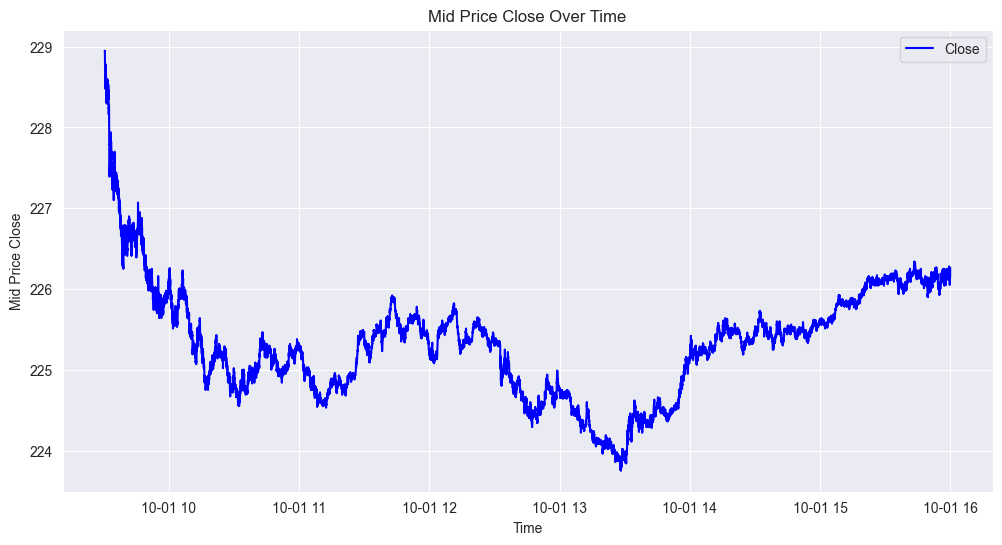

In [7]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data["trade_close"], label="Close", color="blue")
plt.xlabel("Time")
plt.ylabel("Mid Price Close")
plt.title("Mid Price Close Over Time")
plt.legend()
plt.show()

In [8]:
# Data Splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size:train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size:, :]

In [ ]:
from time_series_generators import TimeSeriesGenerator, TimeSeriesScalerGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fit scalers on training data only
minmax_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[features])

# Apply scalers to training, validation, and test sets
# VERIFY if the scaled values are totally unreadable or still manageable
train_scaled = minmax_scaler.transform(train_df[features])
val_scaled = minmax_scaler.transform(val_df[features])
test_scaled = minmax_scaler.transform(test_df[features])

# Extract targets separately
train_target = train_df[prediction_column].values
val_target = val_df[prediction_column].values
test_target = test_df[prediction_column].values

# Create generators with pre-scaled data
train_gen = TimeSeriesGenerator(train_scaled, train_target, look_back=look_back, batch_size=batch_size)
val_gen = TimeSeriesGenerator(val_scaled, val_target, look_back=look_back, batch_size=batch_size)
test_gen = TimeSeriesGenerator(test_scaled, test_target, look_back=look_back, batch_size=batch_size)

In [10]:
from keras import layers, models, optimizers

def create_model():
    input_size = len(features)
    inputs = layers.Input(shape=(look_back, input_size))

    # First LSTM layer
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Second LSTM layer
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Dense layers
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(3, activation="softmax")(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

num_models = 1
epochs = 5
all_predictions = []

for i in range(num_models):
    print(f"Training model {i + 1}/{num_models}")
    tf.random.set_seed(i + 1)
    model = create_model()
    # optimizer = optimizers.Adam(learning_rate=0.001)
    optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    model.fit(train_gen, validation_data=val_gen, epochs=epochs)
    
    predictions = model.predict(test_gen)
    all_predictions.append(predictions)


Training model 1/1
Epoch 1/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4184 - loss: 1.1940 - val_accuracy: 0.4352 - val_loss: 1.0568
Epoch 2/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4551 - loss: 1.0523 - val_accuracy: 0.4230 - val_loss: 1.6665
Epoch 3/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4701 - loss: 1.0256 - val_accuracy: 0.4059 - val_loss: 1.2641
Epoch 4/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4777 - loss: 1.0077 - val_accuracy: 0.4230 - val_loss: 1.9886
Epoch 5/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4808 - loss: 1.0054 - val_accuracy: 0.4059 - val_loss: 2.9410
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_evaluation_metrics(y_true, y_pred, log_probabilities):
    probabilities = np.exp(log_probabilities)
    unique_classes = np.unique(y_true)
    num_classes = len(unique_classes)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    class_labels = ["Down (0)", "Up (1)"] if num_classes == 2 else ["Down (0)", "Constant (1)", "Up (2)"]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[0],
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Histogram of Predicted Probabilities
    for i, class_label in enumerate(class_labels):
        sns.histplot(
            probabilities[y_true == unique_classes[i]][:, i], bins=30, label=class_label, ax=axes[1]
        )
    axes[1].set_title("Probability Distribution")
    axes[1].set_xlabel("Predicted Probability")
    axes[1].legend()

    # Scatter Plot of Predictions
    scatter = sns.scatterplot(
        x=np.arange(len(probabilities)),
        y=probabilities.max(axis=1),
        hue=y_true,
        palette={0: "red", 1: "blue"} if num_classes == 2 else {0: "red", 1: "blue", 2: "green"},
        alpha=0.7,
        ax=axes[2],
    )
    axes[2].set_title("Scatter Plot of Predictions")
    axes[2].set_xlabel("Sample Index")
    axes[2].set_ylabel("Max Predicted Probability")

    handles, labels = scatter.get_legend_handles_labels()
    axes[2].legend(handles, class_labels, title="True Class")

    axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

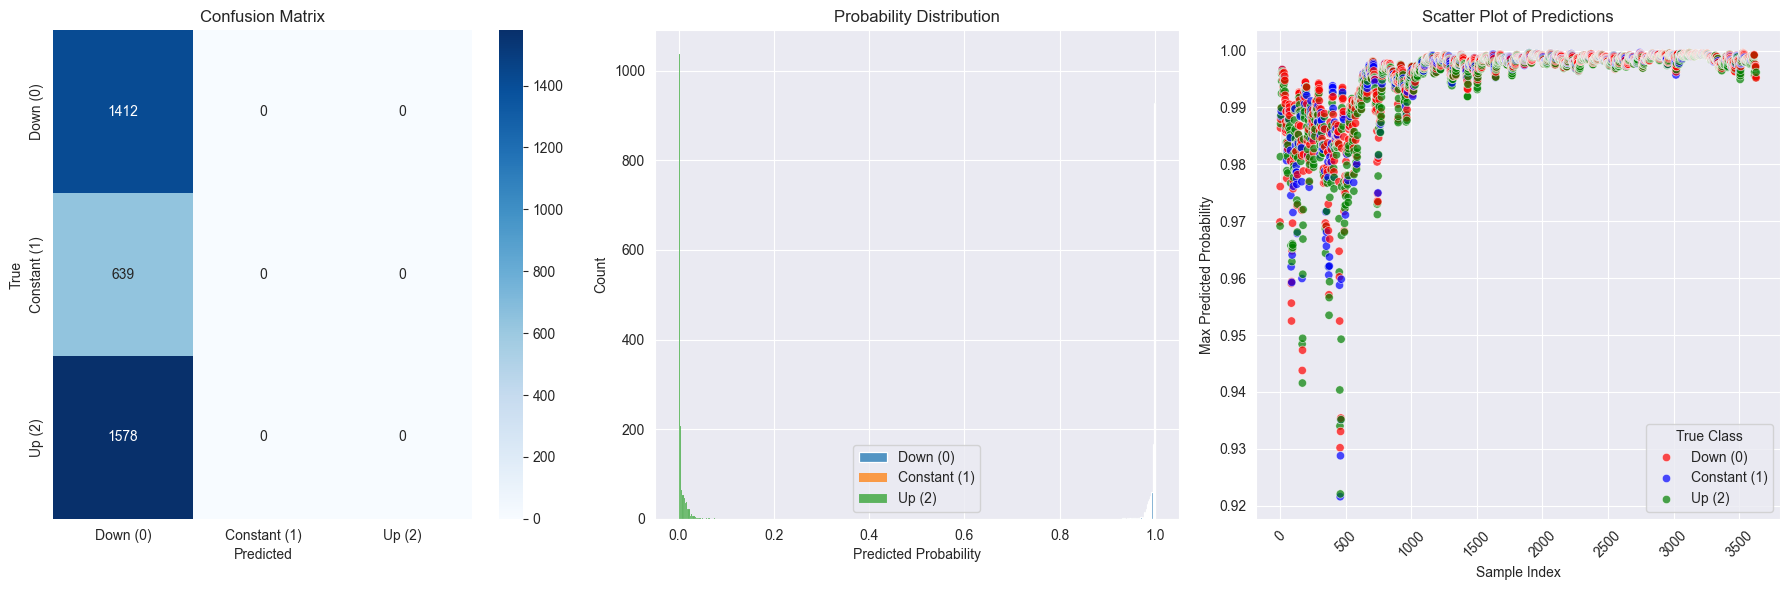

Accuracy: 0.3891
              precision    recall  f1-score   support

           0       0.39      1.00      0.56      1412
           1       0.00      0.00      0.00       639
           2       0.00      0.00      0.00      1578

    accuracy                           0.39      3629
   macro avg       0.13      0.33      0.19      3629
weighted avg       0.15      0.39      0.22      3629



In [ ]:
# Convert predictions to class labels
all_predictions = np.array(all_predictions)
predicted_classes = np.argmax(all_predictions, axis=-1)

# Majority voting
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predicted_classes)

# Compute log probabilities for evaluation
log_probabilities = np.log(np.mean(all_predictions, axis=0))

# Evaluate the final predictions
y_true = test_gen.true_labels  # Assuming test_gen has the true labels

# Ensure log_probabilities shape matches the number of classes in y_true
if len(np.unique(y_true)) == 2:
    log_probabilities = log_probabilities[:, :2]

plot_evaluation_metrics(y_true, final_predictions, log_probabilities)

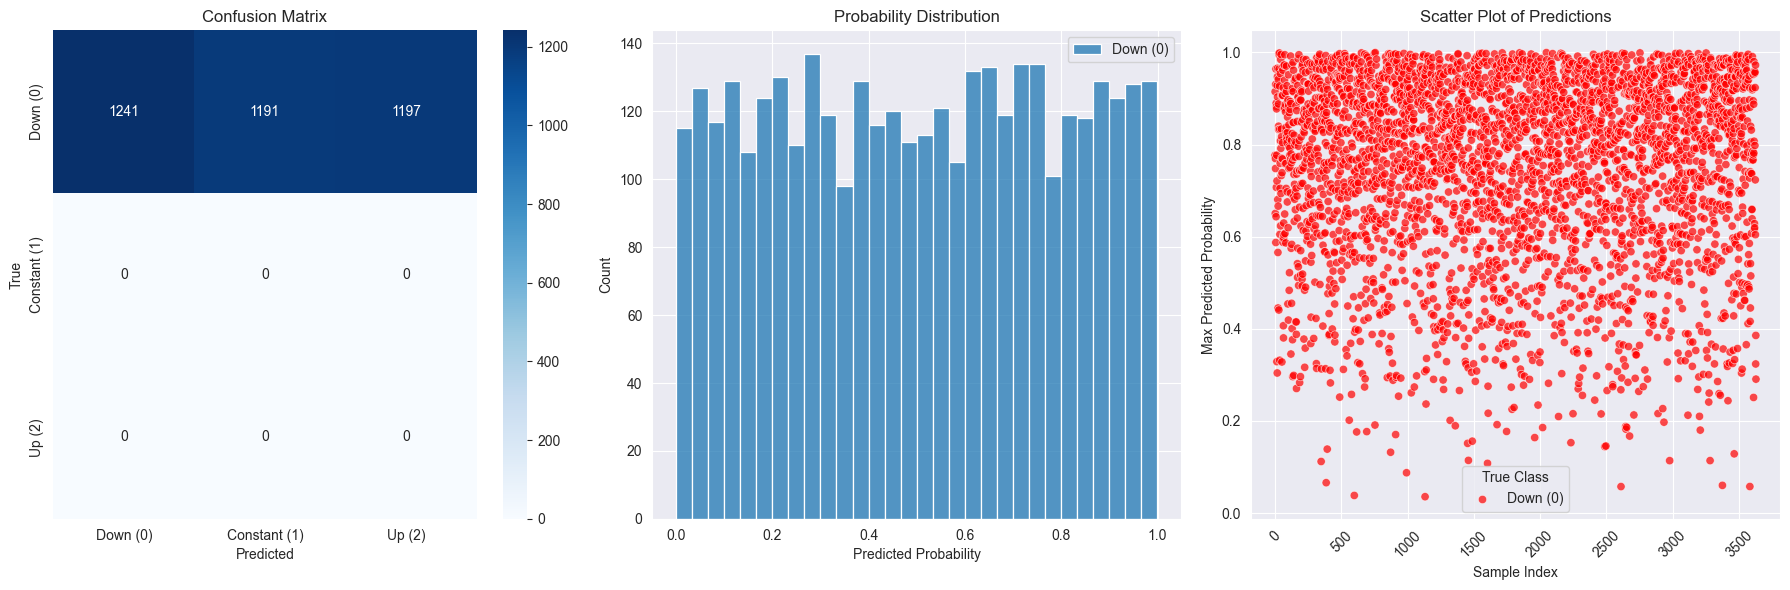

Accuracy: 0.3420
              precision    recall  f1-score   support

           0       1.00      0.34      0.51      3629
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.34      3629
   macro avg       0.33      0.11      0.17      3629
weighted avg       1.00      0.34      0.51      3629



In [ ]:
# Determine the number of classes
num_classes = len(np.unique(final_predictions))

# Implement a random strategy
random_y_pred = np.random.randint(0, num_classes, size=len(final_predictions))
random_log_probabilities = np.log(np.random.rand(len(final_predictions), num_classes))

# Plot evaluation metrics for the random strategy
plot_evaluation_metrics(final_predictions, random_y_pred, random_log_probabilities)